# Preprocessing and Pipelines
Impute missing values, convert categorical data to numeric values, scale data, evaluate multiple supervised learning models simultaneously, and build pipelines to streamline your workflow

## Scikit-learn requirements 
- Numeric data
- No missing values

In [1]:
import pandas as pd
music = pd.read_csv('datasets/music_clean.csv')
print(music.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1000 non-null   int64  
 1   popularity        1000 non-null   float64
 2   acousticness      1000 non-null   float64
 3   danceability      1000 non-null   float64
 4   duration_ms       1000 non-null   float64
 5   energy            1000 non-null   float64
 6   instrumentalness  1000 non-null   float64
 7   liveness          1000 non-null   float64
 8   loudness          1000 non-null   float64
 9   speechiness       1000 non-null   float64
 10  tempo             1000 non-null   float64
 11  valence           1000 non-null   float64
 12  genre             1000 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 101.7 KB
None


## Encoding dummy variables

In [1]:
import pandas as pd
music_df = pd.read_csv("datasets/music_clean.csv")
music_dummies = pd.get_dummies(music_df["genre"], drop_first=True)
print(music_dummies.head())

   1
0  1
1  1
2  1
3  1
4  1


In [3]:
music_dummies = pd.concat([music_df, music_dummies], axis=1)
music_dummies = music_dummies.drop("genre", axis=1)

![resim_2023-04-14_140923957](resim_2023-04-14_140923957.png)


## Creating dummy variables
Being able to include categorical features in the model building process can enhance performance as they may add information that contributes to prediction accuracy.

In [2]:
# Create music_dummies
music_dummies = pd.get_dummies(music_df, drop_first=True)

# Print the new DataFrame's shape
print("Shape of music_dummies: {}".format(music_dummies.shape))

Shape of music_dummies: (1000, 13)


As there were ten values in the "genre" column, nine new columns were added by a call of `pd.get_dummies()` using `drop_first=True`. After dropping the original "`genre`" column, there are still eight new columns in the DataFrame

## Regression with categorical features
Now we have created music_dummies, containing binary features for each song's genre, it's time to build a ridge regression model to predict song popularity.

The model will be evaluated by calculating the average RMSE, but first, we will need to convert the scores for each fold to positive values and take their square root. This metric shows the average error of our model's predictions, so it can be compared against the standard deviation of the target value—"popularity".

In [9]:
# Import necessary modules
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold

# Create X and y
X = music_dummies.drop("popularity", axis=1).values
y = music_dummies["popularity"].values

# Instantiate a ridge model
ridge = Ridge(alpha=0.2)

# Define k-fold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(ridge, X, y, cv=kf, scoring="neg_mean_squared_error")

# Calculate RMSE
rmse = np.sqrt(-scores)
print("Average RMSE: {}".format(np.mean(rmse)))
print("Standard Deviation of the target array: {}".format(np.std(y)))

Average RMSE: 10.033098690539362
Standard Deviation of the target array: 14.02156909907019


An average RMSE of approximately 10.03 is lower than the standard deviation of the target variable (song popularity), suggesting the model is reasonably accurate.

## Dropping missing data
Over the next three exercises, we are going to tidy the music_df dataset. We will create a pipeline to impute missing values and build a KNN classifier model, then use it to predict whether a song is of the "Rock" genre.

Now, we will drop missing values accounting for less than 5% of the dataset, and convert the "genre" column into a binary feature.

In [10]:
# Print missing values for each column
print(music_df.isna().sum().sort_values())

# Remove values where less than 5% are missing
music_df = music_df.dropna(subset=["genre", "popularity", "loudness", "liveness", "tempo"])

# Convert genre to a binary feature
music_df["genre"] = np.where(music_df["genre"] == "Rock", 1, 0)

print(music_df.isna().sum().sort_values())
print("Shape of the `music_df`: {}".format(music_df.shape))

Unnamed: 0          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64
Unnamed: 0          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64
Shape of the `music_df`: (1000, 13)


## Pipeline for song genre prediction: I
Now it's time to build a pipeline. It will contain steps to impute missing values using the mean for each feature and build a KNN model for the classification of song genre.

In [12]:
# Import modules
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# Instantiate an imputer
imputer = SimpleImputer()

# Instantiate a knn model
knn = KNeighborsClassifier(n_neighbors=3)

# Build steps for the pipeline
steps = [("imputer", imputer), 
         ("knn", knn)]

## Pipeline for song genre prediction: II
Having set up the steps of the pipeline in the previous exercise, you will now use it on the music_df dataset to classify the genre of songs. What makes pipelines so incredibly useful is the simple interface that they provide.

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Load data into a pandas DataFrame
df = pd.read_csv('datasets/music_clean.csv')

# Check if 'target' is a valid column name
if 'target' not in df.columns:
    raise ValueError("Column 'target' not found in DataFrame")

# Split the data into training and testing sets
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the imputer
imp_mean = SimpleImputer(strategy='mean')

# Define the classifier
knn = KNeighborsClassifier()

steps = [("imputer", imp_mean),
        ("knn", knn)]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

In [ ]:
<script.py> output:
    [[79  9]
     [ 4 82]]

## Centering and scaling for regression

In [ ]:
# Import StandardScaler and Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X = df.drop(['target'], axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline steps
steps = [("scaler", StandardScaler()),
         ("lasso", Lasso(alpha=0.5))]

# Instantiate the pipeline
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

# Calculate and print R-squared
print(pipeline.score(X_test, y_test))

In [ ]:
<script.py> output:
    0.6193523316282489

The model may have only produced an R-squared of 0.619, but without scaling this exact model would have only produced a score of 0.35, which proves just how powerful scaling can be

## Centering and scaling for classification

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Build the steps
steps = [("scaler", StandardScaler()),
         ("logreg", LogisticRegression())]
pipeline = Pipeline(steps)

# Create the parameter space
parameters = {"logreg__C": np.linspace(0.001, 1.0, 20)}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=21)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training data
cv.fit(X_train, y_train)
print(cv.best_score_, "\n", cv.best_params_)

0.05500000000000001 
 {'logreg__C': 0.6319473684210526}


Using a pipeline shows that a logistic regression model with "C" set to approximately 0.01 produces a model with 0.6319 accuracy!

## Visualizing regression model performance
Now we have seen how to evaluate multiple models out of the box, we will build three regression models to predict a song's "energy" levels.

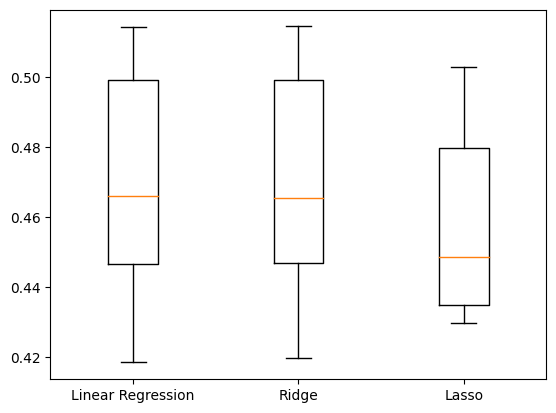

In [29]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt

models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.1), "Lasso": Lasso(alpha=0.1)}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)
  
# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

Lasso regression is not a good model for this problem, while linear regression and ridge perform fairly equally. 

## Predicting on the test set

In [ ]:
# Import mean_squared_error
from sklearn.metrics import mean_squared_error

for name, model in models.items():
  
  # Fit the model to the training data
  model.fit(X_train_scaled, y_train)
  
  # Make predictions on the test set
  y_pred = model.predict(X_test_scaled)
  
  # Calculate the test_rmse
  test_rmse = mean_squared_error(y_test, y_pred, squared=False)
  print("{} Test Set RMSE: {}".format(name, test_rmse))

In [ ]:
<script.py> output:
    Linear Regression Test Set RMSE: 0.11988851505947569
    Ridge Test Set RMSE: 0.11987066103299668

The linear regression model just edges the best performance, although the difference is a RMSE of 0.00001 for popularity! Now let's look at classification model selection.

## Visualizing classification model performance

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create models dictionary
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(), "Decision Tree Classifier": DecisionTreeClassifier()}
results = []

# Loop through the models' values
for model in models.values():
  
  # Instantiate a KFold object
  kf = KFold(n_splits=6, random_state=12, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
  results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.show()

![resim_2023-05-05_194130492](resim_2023-05-05_194130492.png)


Looks like logistic regression is the best candidate based on the cross-validation results! Let's wrap up by building a pipeline

## Pipeline for predicting song popularity

In [ ]:
# Create steps
steps = [("imp_mean", SimpleImputer()), 
         ("scaler", StandardScaler()), 
         ("logreg", LogisticRegression())]

# Set up pipeline
pipeline = Pipeline(steps)
params = {"logreg__solver": ["newton-cg", "saga", "lbfgs"],
         "logreg__C": np.linspace(0.001, 1.0, 10)}

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

# Compute and print performance
print("Tuned Logistic Regression Parameters: {}, Accuracy: {}".format(tuning.best_params_, tuning.score(X_test, y_test)))

In [ ]:
<script.py> output:
    Tuned Logistic Regression Parameters: {'logreg__C': 0.112, 'logreg__solver': 'newton-cg'}, Accuracy: 0.82

We've selected a model, built a preprocessing pipeline, and performed hyperparameter tuning to create a model that is 82% accurate in predicting song genres